### Week 5
### DSC 650
### Abed Tabbalat

In [1]:
# Mounting drive
import os
from google.colab import drive
drive.mount('/content/drive', force_remount = True)
os.chdir('/content/drive/My Drive/DSC650/Original/dsc650/assignments/assignment05')
!pwd

Mounted at /content/drive
/content/drive/MyDrive/DSC650/Original/dsc650/assignments/assignment05


In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras import models
from keras import layers
from keras.datasets import boston_housing


## Importing Data

In [3]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

57026/57026 [==============================] - 0s 0us/step


In [4]:
# Trained data shape
train_data.shape

(404, 13)

In [5]:
# Test data shape
test_data.shape

(102, 13)

In [6]:
# Targets
train_targets

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13

## Data Prep

In [7]:
mean = train_data.mean(axis = 0)
train_data -= mean
std = train_data.std(axis = 0)
train_data /= std

test_data -= mean
test_data /= std

## Model

In [8]:
def build_model(input_shape):
    # Define the neural network model architecture
    model = models.Sequential([
        layers.Dense(64, activation='relu', input_shape=input_shape),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])

    # Compile the model with the optimizer, loss function, and evaluation metric
    model.compile(optimizer='rmsprop',
                  loss='mse',  # mean squared error
                  metrics=['mae'])  # mean absolute error
    
    return model


In [9]:
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

# Split the data into K folds for cross-validation
for i in range(k):
    print(f"Processing fold #{i}")

    # Prepare the validation data for this fold
    val_data = train_data[i*num_val_samples: (i+1)*num_val_samples]
    val_targets = train_targets[i*num_val_samples: (i+1)*num_val_samples]

    # Prepare the training data for this fold
    partial_train_data = np.concatenate(
        [train_data[:i*num_val_samples],
         train_data[(i+1)*num_val_samples:]],
        axis=0
    )
    partial_train_targets = np.concatenate(
        [train_targets[:i*num_val_samples],
         train_targets[(i+1)*num_val_samples:]],
        axis=0
    )

    # Build the Keras model
    model = build_model(input_shape=(train_data.shape[1],))

    # Train the model on the training data for this fold
    model.fit(partial_train_data, partial_train_targets, 
              epochs=num_epochs, batch_size=1, verbose=0)

    # Evaluate the model on the validation data for this fold
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)


Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


In [11]:
print(f'Scores: {all_scores}')

Scores: [1.811415672302246, 2.7241051197052, 2.4456658363342285, 2.4289543628692627]


In [12]:
print(f'Mean: {np.mean(all_scores)}') 

Mean: 2.3525352478027344


In [13]:
num_epochs = 500
all_mae_histories = []

# Loop through the K folds for cross-validation
for i in range(k):
    print(f"Processing fold #{i}")

    # Prepare the validation data for this fold
    val_data = train_data[i*num_val_samples: (i+1)*num_val_samples]
    val_targets = train_targets[i*num_val_samples: (i+1)*num_val_samples]

    # Prepare the training data for this fold
    partial_train_data = np.concatenate(
        [train_data[:i*num_val_samples],
         train_data[(i+1)*num_val_samples:]],
        axis=0
    )
    partial_train_targets = np.concatenate(
        [train_targets[:i*num_val_samples],
         train_targets[(i+1)*num_val_samples:]],
        axis=0
    )

    # Build the Keras model
    model = build_model(input_shape=(train_data.shape[1],))

    # Train the model on the training data for this fold, and record the validation MAE for each epoch
    history = model.fit(partial_train_data, partial_train_targets, 
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)

    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


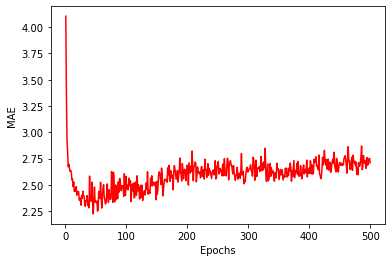

In [14]:
# Compute the average MAE over all folds for each epoch
avg_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

# Plot the average MAE history over epochs
plt.plot(range(1, num_epochs+1), avg_mae_history, color='red')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.show()

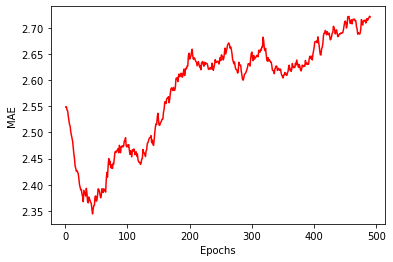

In [15]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous*factor + point*(1-factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# Smooth the MAE curve by taking a moving average
smooth_mae_history = smooth_curve(avg_mae_history[10:])

# Plot the smoothed MAE curve over epochs
plt.plot(range(1, len(smooth_mae_history)+1), smooth_mae_history, color='red')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.show()

In [16]:
# Build a fresh Keras model
model = build_model(input_shape=(train_data.shape[1],))

# Train the model on the entire dataset
model.fit(train_data, train_targets,
          epochs=80, batch_size=16, verbose=0)

# Evaluate the model on the test set and record the test MSE and MAE
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 4ms/step - loss: 17.3967 - mae: 2.5874


In [17]:
print(f'MAE: {test_mae_score}')

MAE: 2.5873796939849854
